In [1]:
import georinex as gr
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
from scipy.optimize import curve_fit, leastsq
from scipy import signal
from scipy.interpolate import RectBivariateSpline
import os
import re

# for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from curlyBrace import curlyBrace

# for data
from dataclasses import dataclass, field
from typing import Optional, List

# own functions
from sv_functions import *
from data_selector import data_selector

# for warnings
import warnings
warnings.filterwarnings("ignore", message="On entry to DLASCL parameter number 4 had an illegal value")


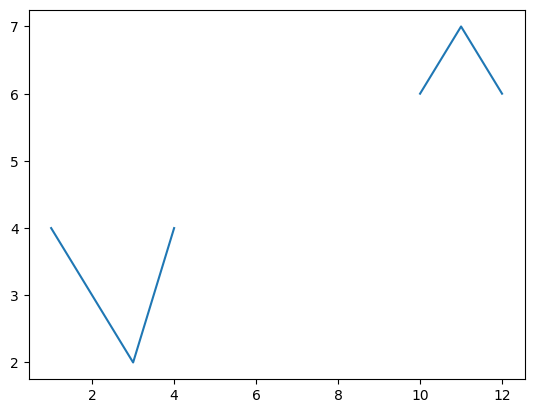

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Original data
x = np.array([1, 2, 3, 4, 10, 11, 12],dtype=np.float64)
y = np.array([4, 3, 2, 4, 6, 7, 6],dtype=np.float64)

# Create new arrays with NaN to create the gap
x_new = np.insert(x, 4, np.nan)  # Insert NaN at index 4
y_new = np.insert(y, 4, np.nan)  # Insert NaN at index 4

# Plot the data
plt.figure()
plt.plot(x_new, y_new)
plt.show()


In [2]:
@dataclass
class SV:
    sv_id: Optional[str] = None
    time: Optional[List[np.datetime64]] = field(default_factory=list)
    elevation: Optional[List[float]] = field(default_factory=list)
    azimuth: Optional[List[float]] = field(default_factory=list)
    CN0: Optional[List[float]] = field(default_factory=list)
    Am: Optional[List[float]] = field(default_factory=list)
    Ad: Optional[List[float]] = field(default_factory=list)

@dataclass
class SVData:
    sv: List[SV] = None

    def get_sv(self, sv_id: str) -> Optional[SV]:
        for sv_obj in self.sv:
            if sv_obj.sv_id == sv_id:
                return sv_obj
        return None

    def add_sv(self, sv_obj: SV):
        if self.sv is None:
            self.sv = []
        self.sv.append(sv_obj)

    def add_data_to_sv(self, sv_id: str, field_name: str, data: List):
        for sv_obj in self.sv:
            if sv_obj.sv_id == sv_id:
                if getattr(sv_obj, field_name) is None:
                    setattr(sv_obj, field_name, [])
                getattr(sv_obj, field_name).extend(data)
                break

def get_date(path):
    expression = r'\d{6}'

    return re.search(expression,path)[0]

In [3]:
files = data_selector()

if len(files) == 6:
    obs_short, nav_short, obs_medium, nav_medium, obs_long, nav_long = files

    if 'glass' in obs_short:
        wall_type = 'glass'
        perp_from_wall = 195 # deg
    elif 'metal' in obs_short:
        wall_type = 'metal'
        perp_from_wall = 286 # deg
    elif 'brick' in obs_short:
        wall_type = 'brick'
        perp_from_wall = 106 # deg
    else:
        wall_type = ''
        perp_from_wall = 0

    date = get_date(obs_short)

    if 'galileo' in nav_short:
        obs_short = gr.load(obs_short,use="E")
        obs_medium = gr.load(obs_medium,use="E")
        obs_long = gr.load(obs_long,use="E")
        nav_short = gr.load(nav_short)
        nav_medium = gr.load(nav_medium)
        nav_long = gr.load(nav_long)
        system = 'galileo'
    else:
        obs_short = gr.load(obs_short,use="G")
        obs_medium = gr.load(obs_medium,use="G")
        obs_long = gr.load(obs_long,use="G")
        nav_short = gr.load(nav_short)
        nav_medium = gr.load(nav_medium)
        nav_long = gr.load(nav_long)
        system = 'gps'
elif len(files) == 4:
    obs_main, nav_main, obs_aux, nav_aux = files

    if 'glass' in obs_main:
        wall_type = 'glass'
        perp_from_wall = 195 # deg
    elif 'metal' in obs_main:
        wall_type = 'metal'
        perp_from_wall = 286 # deg
    elif 'brick' in obs_main:
        wall_type = 'brick'
        perp_from_wall = 106 # deg
    else:
        wall_type = 'clean'
        perp_from_wall = 0

    date = get_date(obs_main)

    if 'galileo' in nav_main:
        obs_main = gr.load(obs_main,use="E")
        obs_aux = gr.load(obs_aux,use="E")
        nav_main = gr.load(nav_main)
        nav_aux = gr.load(nav_aux)
        system = 'galileo'
    else:
        obs_main = gr.load(obs_main,use="G")
        obs_aux = gr.load(obs_aux,use="G")
        nav_main = gr.load(nav_main)
        nav_aux = gr.load(nav_aux)
        system = 'gps'


if not wall_type == 'clean':
    title_string = f'10 m to {wall_type} wall'
else:
    title_string = f'clear sky conditions'

You selected: metal
You selected: 10m
Only one date available. 290324 has been picked.
You picked GPS.
There was found 2 different serial numbers in the folder. Checking polarization.
Polarization file found!
Loading 3633416 as LHP
Loading 3632777 as RHP


In [4]:
# constants

freq_L1 = 10.23e06 * 154 # Hz
freq_L2 = 10.23e06 * 120 # Hz
freq_L5 = 10.23e06 * 115 # Hz
c = 299792458 # m/s

alpha = nav_main.ionospheric_corr_GPS[:4]
beta = nav_main.ionospheric_corr_GPS[4:]

pseudorange_L1_selector = 'C1C'
pseudorange_L2_selector = 'C2L'
pseudorange_L5_selector = 'C5Q'
carrier_phase_L1_selector = 'L1C'
carrier_phase_L2_selector = 'L2L'
carrier_phase_L5_selector = 'L5Q'

# true position
true_pos_ecef = np.array(obs_main.position)
true_pos_lla = ecef_to_lla(true_pos_ecef[0],true_pos_ecef[1],true_pos_ecef[2])

# bands to use:
USE_L1 = True
USE_L2 = True
USE_L5 = True

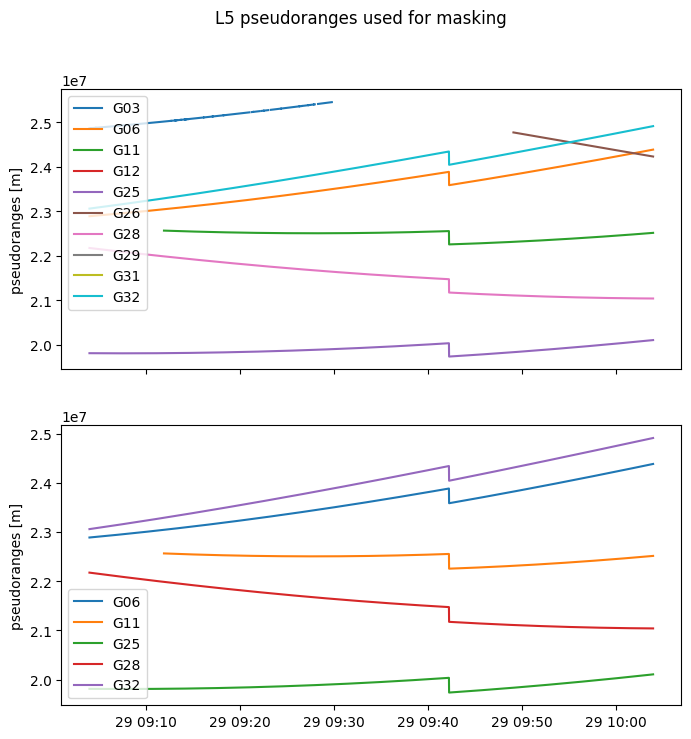

In [5]:
len_of_t = len(obs_main.time.values)

sv_list = obs_main.sv.values
# condition = len_of_t//1 # gnss-sdr
condition = len_of_t//2 # mosaic
sv_selector = np.array(np.sum(np.isnan(obs_main.sel(sv=sv_list)[pseudorange_L5_selector].values),axis=0)<condition)
sv_list = sv_list[sv_selector]

if USE_L1:
    pseudoranges_L1 = obs_main.sel(sv=sv_list)[pseudorange_L1_selector].values
if USE_L2:
    pseudoranges_L2 = obs_main.sel(sv=sv_list)[pseudorange_L2_selector].values
if USE_L5:
    pseudoranges_L5 = obs_main.sel(sv=sv_list)[pseudorange_L5_selector].values

fig, ax = plt.subplots(2,1,figsize=(8,8),sharex=True)
fig.suptitle('L5 pseudoranges used for masking')
for _, sv in enumerate(obs_main.sv.values):
    ax[0].plot(obs_main[pseudorange_L1_selector].sel(sv=sv).time.values,obs_main.sel(sv=sv)[pseudorange_L5_selector].values, label=f'{sv}')
ax[0].set_ylabel('pseudoranges [m]')
ax[0].legend()
for idx, sv in enumerate(sv_list):
    ax[1].plot(obs_main[pseudorange_L1_selector].sel(sv=sv).time.values,pseudoranges_L5[:,idx],label=f'{sv}')
ax[1].set_ylabel('pseudoranges [m]')
ax[1].legend()
plt.show()

In [6]:
SAASTAMOINEN_CORRECTION = False # not used - will look at median position calculated and compare with that to not interrupt the direct signal received
KLOBUCHAR_CORRECTION = False # not used - will look at median position calculated and compare with that to not interrupt the direct signal received
IONOSPHERIC_FREE_COMBINATION_CORRECTION = False # not applicable for now (not useful for multipath detection)
MULTIPATH_CORRECTION = False # doesn't seem to work with pseudoranges :)

# initialize 
if USE_L1:
    sat_positions_L1 = np.zeros((len(sv_list),3,len_of_t))
    sat_clock_relativistic_correction_L1 = np.zeros((len(sv_list), len_of_t))
    az_L1 = np.zeros((len(sv_list),len_of_t))
    el_L1 = np.zeros_like(az_L1)
if USE_L2:
    sat_positions_L2 = np.zeros((len(sv_list),3,len_of_t))
    sat_clock_relativistic_correction_L2 = np.zeros((len(sv_list), len_of_t))
    az_L2 = np.zeros((len(sv_list),len_of_t))
    el_L2 = np.zeros_like(az_L2)
if USE_L5:
    sat_positions_L5 = np.zeros((len(sv_list),3,len_of_t))
    sat_clock_relativistic_correction_L5 = np.zeros((len(sv_list), len_of_t))
    az_L5 = np.zeros((len(sv_list),len_of_t))
    el_L5 = np.zeros_like(az_L5)


R_L = R1(90-true_pos_lla[0],deg=True)@R3(true_pos_lla[1]+90,deg=True)

## computing
for t_i in tqdm(range(len_of_t), desc="Progress", leave=False):
    # calculate satellite positions

    _, tow = datetime_to_gpsweek(obs_main.time.values[t_i])
    for j in range(len(sv_list)):
        if USE_L1:
            sat_pos, _, sat_clock_relativistic_correction_L1[j,t_i] = calcSatPos(nav_main, tow-pseudoranges_L1[t_i,j]/c, sv_list[j], True)
            sat_positions_L1[j,:,t_i] = earth_rotation_correction(pseudoranges_L1[t_i,j]/c + sat_clock_relativistic_correction_L1[j,t_i], sat_pos.T)

            sat_ENU = (R_L @ (sat_positions_L1[j,:,t_i].reshape((-1,1)) - true_pos_ecef.reshape((-1,1))))
            # calculate azimuth and zenith
            azimuth = np.arctan2(sat_ENU[0], sat_ENU[1])
            azimuth = np.rad2deg(azimuth[0])
            zenith = np.arccos(sat_ENU[2] / np.sqrt(sat_ENU[0]**2 + sat_ENU[1]**2 + sat_ENU[2]**2))  
            zenith = np.rad2deg(zenith[0])

            if azimuth < 0:
                azimuth = 360 + azimuth

            if ((90-zenith) > 0):
                az_L1[j,t_i] = azimuth
                el_L1[j,t_i] = 90-zenith
            else:
                az_L1[j,t_i] = np.nan
                el_L1[j,t_i] = np.nan
        if USE_L2:
            sat_pos, _, sat_clock_relativistic_correction_L2[j,t_i] = calcSatPos(nav_main, tow-pseudoranges_L2[t_i,j]/c, sv_list[j], use_iono_free_correction=IONOSPHERIC_FREE_COMBINATION_CORRECTION,)
            sat_positions_L2[j,:,t_i] = earth_rotation_correction(pseudoranges_L2[t_i,j]/c + sat_clock_relativistic_correction_L2[j,t_i], sat_pos.T)

            sat_ENU = (R_L @ (sat_positions_L2[j,:,t_i].reshape((-1,1)) - true_pos_ecef.reshape((-1,1))))
            # calculate azimuth and zenith
            azimuth = np.arctan2(sat_ENU[0], sat_ENU[1])
            azimuth = np.rad2deg(azimuth[0])
            zenith = np.arccos(sat_ENU[2] / np.sqrt(sat_ENU[0]**2 + sat_ENU[1]**2 + sat_ENU[2]**2))  
            zenith = np.rad2deg(zenith[0])

            if azimuth < 0:
                azimuth = 360 + azimuth

            if ((90-zenith) > 0):
                az_L2[j,t_i] = azimuth
                el_L2[j,t_i] = 90-zenith
            else:
                az_L2[j,t_i] = np.nan
                el_L2[j,t_i] = np.nan
        if USE_L5:
            sat_pos, _, sat_clock_relativistic_correction_L5[j,t_i] = calcSatPos(nav_main, tow-pseudoranges_L5[t_i,j]/c, sv_list[j], True)
            sat_positions_L5[j,:,t_i] = earth_rotation_correction(pseudoranges_L5[t_i,j]/c + sat_clock_relativistic_correction_L5[j,t_i], sat_pos.T)

            sat_ENU = (R_L @ (sat_positions_L5[j,:,t_i].reshape((-1,1)) - true_pos_ecef.reshape((-1,1))))
            # calculate azimuth and zenith
            azimuth = np.arctan2(sat_ENU[0], sat_ENU[1])
            azimuth = np.rad2deg(azimuth[0])
            zenith = np.arccos(sat_ENU[2] / np.sqrt(sat_ENU[0]**2 + sat_ENU[1]**2 + sat_ENU[2]**2))  
            zenith = np.rad2deg(zenith[0])

            if azimuth < 0:
                azimuth = 360 + azimuth

            if ((90-zenith) > 0):
                az_L5[j,t_i] = azimuth
                el_L5[j,t_i] = 90-zenith
            else:
                az_L5[j,t_i] = np.nan
                el_L5[j,t_i] = np.nan


Progress:   0%|          | 0/3601 [00:00<?, ?it/s]

In [7]:
if USE_L1:
    pseudoranges_L1 = obs_main.sel(sv=sv_list)[pseudorange_L1_selector].values
if USE_L2:
    pseudoranges_L2 = obs_main.sel(sv=sv_list)[pseudorange_L2_selector].values
if USE_L5:
    pseudoranges_L5 = obs_main.sel(sv=sv_list)[pseudorange_L5_selector].values

if SAASTAMOINEN_CORRECTION:
    for j in range(len(sv_list)):
        d_trop_L1 = saastamoinen_correction(el_L1[j,:], true_pos_lla[0], true_pos_lla[2]/1000, 1013, 18+273.15, 0.5)
        pseudoranges_L1[:,j] -= d_trop_L1
        d_trop_L2 = saastamoinen_correction(el_L2[j,:], true_pos_lla[0], true_pos_lla[2]/1000, 1013, 18+273.15, 0.5)
        pseudoranges_L2[:,j] -= d_trop_L2
        d_trop_L5 = saastamoinen_correction(el_L5[j,:], true_pos_lla[0], true_pos_lla[2]/1000, 1013, 18+273.15, 0.5)
        pseudoranges_L5[:,j] -= d_trop_L5

if KLOBUCHAR_CORRECTION:
    for i, t in enumerate(obs_main.time.values):
        _, tow = datetime_to_gpsweek(t)
        for j in range(len(sv_list)):
            d_ion_L1 = klobuchar_correction(true_pos_lla[0], true_pos_lla[1], el_L1[j,i], az_L1[j,i], alpha, beta, tow)
            pseudoranges_L1[i,j] -= d_ion_L1
            d_ion_L2 = klobuchar_correction(true_pos_lla[0], true_pos_lla[1], el_L2[j,i], az_L2[j,i], alpha, beta, tow)
            pseudoranges_L2[i,j] -= d_ion_L2
            d_ion_L5 = klobuchar_correction(true_pos_lla[0], true_pos_lla[1], el_L5[j,i], az_L5[j,i], alpha, beta, tow)
            pseudoranges_L5[i,j] -= d_ion_L5

if MULTIPATH_CORRECTION:
    for idx, sv in enumerate(sv_list):
        carrier_phase_L1 = obs_main[carrier_phase_L1_selector].sel(sv=sv).values # in cycles
        carrier_phase_L2 = obs_main[carrier_phase_L2_selector].sel(sv=sv).values # in cycles
        carrier_phase_L5 = obs_main[carrier_phase_L5_selector].sel(sv=sv).values # in cycles
    
        MP_L1 = calculate_multipath_error(pseudoranges_L1[:,idx], freq_L1, carrier_phase_L1, freq_L5, carrier_phase_L5)
        MP_L2 = calculate_multipath_error(pseudoranges_L2[:,idx], freq_L2, carrier_phase_L2, freq_L5, carrier_phase_L5)
        MP_L5 = calculate_multipath_error(pseudoranges_L5[:,idx], freq_L5, carrier_phase_L5, freq_L1, carrier_phase_L1)
    
        pseudoranges_L1[:,idx] -= MP_L1
        pseudoranges_L2[:,idx] -= MP_L2
        pseudoranges_L5[:,idx] -= MP_L5
    


In [8]:
if USE_L1:
    calculated_position_L1 = np.zeros((len_of_t, 3)) * np.nan
if USE_L2:
    calculated_position_L2 = np.zeros((len_of_t, 3)) * np.nan
if USE_L5:
    calculated_position_L5 = np.zeros((len_of_t, 3)) * np.nan

clock_error = np.zeros((len_of_t,3))

for t_i in range(len_of_t):
    conditions = []
    if USE_L1:
        conditions.append(~np.isnan(pseudoranges_L1[t_i]))
    if USE_L2:
        conditions.append(~np.isnan(pseudoranges_L2[t_i]))
    if USE_L5:
        conditions.append(~np.isnan(pseudoranges_L5[t_i]))
    
    if conditions:
        combined_condition = conditions[0]
        for condition in conditions[1:]:
            combined_condition &= condition
        nan_idx = np.where(combined_condition)[0]
    else:
        nan_idx = np.array([])

    if len(nan_idx) < 4:
        continue
    
    if USE_L1:
        try:
            calculated_position_L1[t_i], clock_error[t_i,0] = least_squares_pseudoranges(pseudoranges_L1[t_i,nan_idx]+c*sat_clock_relativistic_correction_L1[nan_idx,t_i], sat_positions_L1[nan_idx,:,t_i], iter_max=25)
        except np.linalg.LinAlgError as err:
            calculated_position_L1[t_i], clock_error[t_i,1] = np.array([np.nan,np.nan,np.nan]), np.nan
    if USE_L2:
        try:
            calculated_position_L2[t_i], clock_error[t_i,1] = least_squares_pseudoranges(pseudoranges_L2[t_i,nan_idx]+c*sat_clock_relativistic_correction_L2[nan_idx,t_i], sat_positions_L2[nan_idx,:,t_i], iter_max=25)
        except np.linalg.LinAlgError as err:
            calculated_position_L2[t_i], clock_error[t_i,1] = np.array([np.nan,np.nan,np.nan]), np.nan
    if USE_L5:
        try:
            calculated_position_L5[t_i], clock_error[t_i,2] = least_squares_pseudoranges(pseudoranges_L5[t_i,nan_idx]+c*sat_clock_relativistic_correction_L5[nan_idx,t_i], sat_positions_L5[nan_idx,:,t_i], iter_max=25)
        except np.linalg.LinAlgError as err:
            calculated_position_L5[t_i], clock_error[t_i,1] = np.array([np.nan,np.nan,np.nan]), np.nan


if USE_L1:
    diff_L1_true_pos = np.zeros(len(calculated_position_L1)) * np.nan
    diff_L1_median_pos = np.zeros_like(diff_L1_true_pos) * np.nan
    for i in range(len(calculated_position_L1)):
        diff_L1_true_pos[i] = np.linalg.norm(true_pos_ecef - calculated_position_L1[i])

if USE_L2:
    diff_L2_true_pos = np.zeros(len(calculated_position_L2)) * np.nan
    diff_L2_median_pos = np.zeros_like(diff_L2_true_pos) * np.nan
    for i in range(len(calculated_position_L2)):
        diff_L2_true_pos[i] = np.linalg.norm(true_pos_ecef - calculated_position_L2[i])

if USE_L5:
    diff_L5_true_pos = np.zeros(len(calculated_position_L5)) * np.nan
    diff_L5_median_pos = np.zeros_like(diff_L5_true_pos) * np.nan
    for i in range(len(calculated_position_L5)):
        diff_L5_true_pos[i] = np.linalg.norm(true_pos_ecef - calculated_position_L5[i])

calculated_positions = []
if USE_L1:
    calculated_positions.append(calculated_position_L1)
if USE_L2:
    calculated_positions.append(calculated_position_L2)
if USE_L5:
    calculated_positions.append(calculated_position_L5)

calculated_position = np.vstack(calculated_positions)

for i in range(len(calculated_position_L1)):
    if USE_L1:
        diff_L1_median_pos[i] = np.linalg.norm(np.nanmedian(calculated_position,axis=0) - calculated_position_L1[i])
    if USE_L2:
        diff_L2_median_pos[i] = np.linalg.norm(np.nanmedian(calculated_position,axis=0) - calculated_position_L2[i])
    if USE_L5:
        diff_L5_median_pos[i] = np.linalg.norm(np.nanmedian(calculated_position,axis=0) - calculated_position_L5[i])

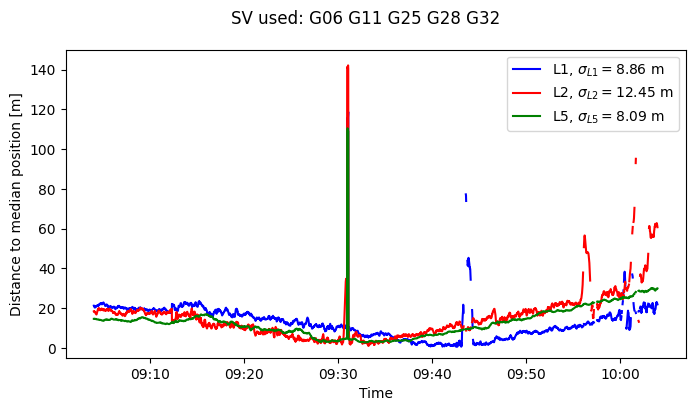

In [11]:
REMOVE_OUTLIERS = True
USE_BRACE = False

def diff_with_padding(arr):
    """Perform differencing with padding to maintain the same dimensions."""
    diff_result = np.diff(arr)
    padded_diff = np.concatenate(([np.nan], diff_result))
    return padded_diff

def moving_average(data, window_size=100):
    """Compute the moving average of a signal."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def generate_datetime_ns(input_string):

    day = int(input_string[:2])
    month = int(input_string[2:4])
    year = int(input_string[4:6])
    hour = int(input_string[7:9])
    minute = int(input_string[9:11])
    second = int(input_string[11:13])

    datetime_string = f'{year+2000:04d}-{month:02d}-{day:02d}T{hour:02d}:{minute:02d}:{second:02d}.000000000'

    datetime_ns = np.datetime64(datetime_string, 'ns')

    return datetime_ns

if REMOVE_OUTLIERS:
    outlier_idx_L1 = np.where(diff_L1_median_pos > 150)[0]
    outlier_idx_L2 = np.where(diff_L2_median_pos > 150)[0]
    outlier_idx_L5 = np.where(diff_L5_median_pos > 150)[0]
    diff_L1_median_pos[outlier_idx_L1] *= np.nan
    diff_L2_median_pos[outlier_idx_L2] *= np.nan
    diff_L5_median_pos[outlier_idx_L5] *= np.nan

fig,ax = plt.subplots(1,1,figsize=(8,4))
fig.suptitle(f'SV used: {" ".join([s for s in sv_list])}')
### L1
col = 'blue'
col2 = 'slate'+col

if not USE_BRACE:
    ax.plot(obs_main.time.values, diff_L1_median_pos, color=col, label=f'L1, $\sigma_{{L1}} = {np.nanstd(diff_L1_median_pos):.2f}$ m')
else:
    ax.plot(datetime_to_decyear(obs_main.time.values), diff_L1_median_pos, color=col, label=f'L1')
### L2
col = 'red'
col2 = 'orange'+col

if not USE_BRACE:
    ax.plot(obs_main.time.values, diff_L2_median_pos, color=col, label=f'L2, $\sigma_{{L2}} = {np.nanstd(diff_L2_median_pos):.2f}$ m')
else:
    ax.plot(datetime_to_decyear(obs_main.time.values), diff_L2_median_pos, color=col, label=f'L2')
### L5
col = 'green'
col2 = 'spring'+col

if not USE_BRACE:
    ax.plot(obs_main.time.values, diff_L5_median_pos, color=col, label=f'L5, $\sigma_{{L5}} = {np.nanstd(diff_L5_median_pos):.2f}$ m')
else:
    ax.plot(datetime_to_decyear(obs_main.time.values), diff_L5_median_pos, color=col, label=f'L5')

ax.set_ylim([-5,150])
ax.set_ylabel('Distance to median position [m]')
ax.set_xlabel('Time')
ax.legend()

if USE_BRACE:
    first_hour = obs_main.time.values[0].astype('datetime64[h]')
    last_hour = obs_main.time.values[-1].astype('datetime64[h]') + np.timedelta64(1,'h')
    delta_time = np.timedelta64(10,'m')
    time_sequence = np.arange(first_hour,last_hour,delta_time)
    idx = np.where(np.isin(obs_main.time.values,time_sequence))[0]

    ax.set_xticks(datetime_to_decyear(obs_main.time.values[idx]))
    ax.set_xticklabels([np.datetime_as_string(decimal_year_to_datetime(ticks), unit='h')[-2:] + ':' + np.datetime_as_string(decimal_year_to_datetime(ticks), unit='m')[-2:] for ticks in ax.get_xticks()])
else:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


if USE_BRACE:
    brace_color = 'black'
    lw = 1
    int_line_num = 4
    font = {'family': 'serif',
            'color':  'k',
            'style': 'normal',
            'size': 10,
            }

    input_string_start = f'{date}:091100'
    input_string_end = f'{date}:094900'

    search_time_start = generate_datetime_ns(input_string_start)
    search_time_end = generate_datetime_ns(input_string_end)

    starting_index = np.where(obs_main.time.values == search_time_start)[0][0]
    ending_index = np.where(obs_main.time.values == search_time_end)[0][0]

    starting_point_brace = obs_main.time.values[starting_index]
    ending_point_brace = obs_main.time.values[ending_index]
    max_value = np.nanmax(np.hstack([diff_L1_median_pos[starting_index:ending_index],diff_L2_median_pos[starting_index:ending_index],diff_L5_median_pos[starting_index:ending_index]]))

    max_value += 1/2*max_value
    if max_value > 60:
        max_value = 60
    k_r1 = 0.05
    p1 = [datetime_to_decyear(starting_point_brace), max_value]
    p2 = [datetime_to_decyear(ending_point_brace), max_value]

    string_for_brace = f'$\sigma_{{L1}}$ = {np.nanstd(diff_L1_median_pos[starting_index:ending_index]):.2f} m\n\
$\sigma_{{L2}}$ = {np.nanstd(diff_L2_median_pos[starting_index:ending_index]):.2f} m\n\
$\sigma_{{L5}}$ = {np.nanstd(diff_L5_median_pos[starting_index:ending_index]):.2f} m'

    curlyBrace(fig, ax, p1, p2, k_r1, bool_auto=True, str_text=string_for_brace, color=brace_color, lw=lw, int_line_num=int_line_num, fontdict=font)

plt.savefig(f'../figs/std_different_frequencies/{wall_type}_plot_std_different_epoch_ranges_{date}.pdf')
plt.savefig(f'../figs/std_different_frequencies/{wall_type}_plot_std_different_epoch_ranges_{date}.png')
plt.show()

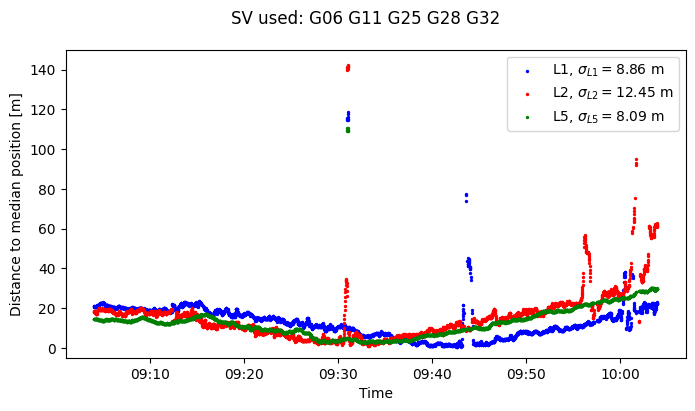

In [12]:
REMOVE_OUTLIERS = True
USE_BRACE = False

def diff_with_padding(arr):
    """Perform differencing with padding to maintain the same dimensions."""
    diff_result = np.diff(arr)
    padded_diff = np.concatenate(([np.nan], diff_result))
    return padded_diff

def moving_average(data, window_size=100):
    """Compute the moving average of a signal."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def generate_datetime_ns(input_string):

    day = int(input_string[:2])
    month = int(input_string[2:4])
    year = int(input_string[4:6])
    hour = int(input_string[7:9])
    minute = int(input_string[9:11])
    second = int(input_string[11:13])

    datetime_string = f'{year+2000:04d}-{month:02d}-{day:02d}T{hour:02d}:{minute:02d}:{second:02d}.000000000'

    datetime_ns = np.datetime64(datetime_string, 'ns')

    return datetime_ns

if REMOVE_OUTLIERS:
    outlier_idx_L1 = np.where(diff_L1_median_pos > 150)[0]
    outlier_idx_L2 = np.where(diff_L2_median_pos > 150)[0]
    outlier_idx_L5 = np.where(diff_L5_median_pos > 150)[0]
    diff_L1_median_pos[outlier_idx_L1] *= np.nan
    diff_L2_median_pos[outlier_idx_L2] *= np.nan
    diff_L5_median_pos[outlier_idx_L5] *= np.nan

fig,ax = plt.subplots(1,1,figsize=(8,4))
fig.suptitle(f'SV used: {" ".join([s for s in sv_list])}')
### L1
col = 'blue'
col2 = 'slate'+col

if not USE_BRACE:
    ax.scatter(obs_main.time.values, diff_L1_median_pos, s=2, color=col, label=f'L1, $\sigma_{{L1}} = {np.nanstd(diff_L1_median_pos):.2f}$ m')
else:
    ax.scatter(datetime_to_decyear(obs_main.time.values), diff_L1_median_pos, s=2, color=col, label=f'L1')
### L2
col = 'red'
col2 = 'orange'+col

if not USE_BRACE:
    ax.scatter(obs_main.time.values, diff_L2_median_pos, s=2, color=col, label=f'L2, $\sigma_{{L2}} = {np.nanstd(diff_L2_median_pos):.2f}$ m')
else:
    ax.scatter(datetime_to_decyear(obs_main.time.values), diff_L2_median_pos, s=2, color=col, label=f'L2')
### L5
col = 'green'
col2 = 'spring'+col

if not USE_BRACE:
    ax.scatter(obs_main.time.values, diff_L5_median_pos, s=2, color=col, label=f'L5, $\sigma_{{L5}} = {np.nanstd(diff_L5_median_pos):.2f}$ m')
else:
    ax.scatter(datetime_to_decyear(obs_main.time.values), diff_L5_median_pos, s=2, color=col, label=f'L5')

ax.set_ylim([-5,150])
ax.set_ylabel('Distance to median position [m]')
ax.set_xlabel('Time')
ax.legend()

if USE_BRACE:
    first_hour = obs_main.time.values[0].astype('datetime64[h]')
    last_hour = obs_main.time.values[-1].astype('datetime64[h]') + np.timedelta64(1,'h')
    delta_time = np.timedelta64(10,'m')
    time_sequence = np.arange(first_hour,last_hour,delta_time)
    idx = np.where(np.isin(obs_main.time.values,time_sequence))[0]

    ax.set_xticks(datetime_to_decyear(obs_main.time.values[idx]))
    ax.set_xticklabels([np.datetime_as_string(decimal_year_to_datetime(ticks), unit='h')[-2:] + ':' + np.datetime_as_string(decimal_year_to_datetime(ticks), unit='m')[-2:] for ticks in ax.get_xticks()])
else:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


if USE_BRACE:
    brace_color = 'black'
    lw = 1
    int_line_num = 4
    font = {'family': 'serif',
            'color':  'k',
            'style': 'normal',
            'size': 10,
            }

    input_string_start = f'{date}:091100'
    input_string_end = f'{date}:094900'

    search_time_start = generate_datetime_ns(input_string_start)
    search_time_end = generate_datetime_ns(input_string_end)

    starting_index = np.where(obs_main.time.values == search_time_start)[0][0]
    ending_index = np.where(obs_main.time.values == search_time_end)[0][0]

    starting_point_brace = obs_main.time.values[starting_index]
    ending_point_brace = obs_main.time.values[ending_index]
    max_value = np.nanmax(np.hstack([diff_L1_median_pos[starting_index:ending_index],diff_L2_median_pos[starting_index:ending_index],diff_L5_median_pos[starting_index:ending_index]]))

    max_value += 1/2*max_value
    if max_value > 60:
        max_value = 60
    k_r1 = 0.05
    p1 = [datetime_to_decyear(starting_point_brace), max_value]
    p2 = [datetime_to_decyear(ending_point_brace), max_value]

    string_for_brace = f'$\sigma_{{L1}}$ = {np.nanstd(diff_L1_median_pos[starting_index:ending_index]):.2f} m\n\
$\sigma_{{L2}}$ = {np.nanstd(diff_L2_median_pos[starting_index:ending_index]):.2f} m\n\
$\sigma_{{L5}}$ = {np.nanstd(diff_L5_median_pos[starting_index:ending_index]):.2f} m'

    curlyBrace(fig, ax, p1, p2, k_r1, bool_auto=True, str_text=string_for_brace, color=brace_color, lw=lw, int_line_num=int_line_num, fontdict=font)

plt.savefig(f'../figs/std_different_frequencies/{wall_type}_scatter_std_different_epoch_ranges_{date}.pdf')
plt.savefig(f'../figs/std_different_frequencies/{wall_type}_scatter_std_different_epoch_ranges_{date}.png')
plt.show()

['G04' 'G11' 'G18' 'G25' 'G26' 'G28']


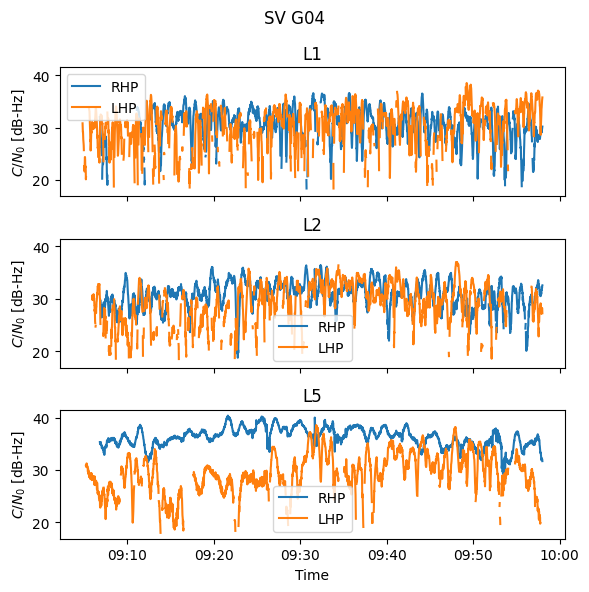

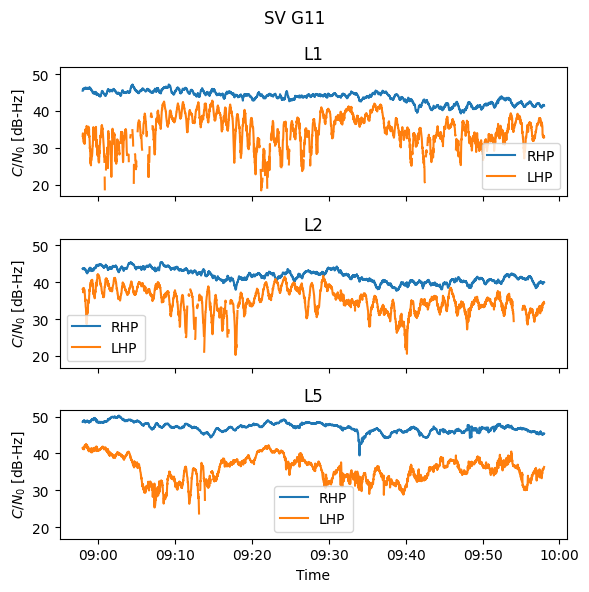

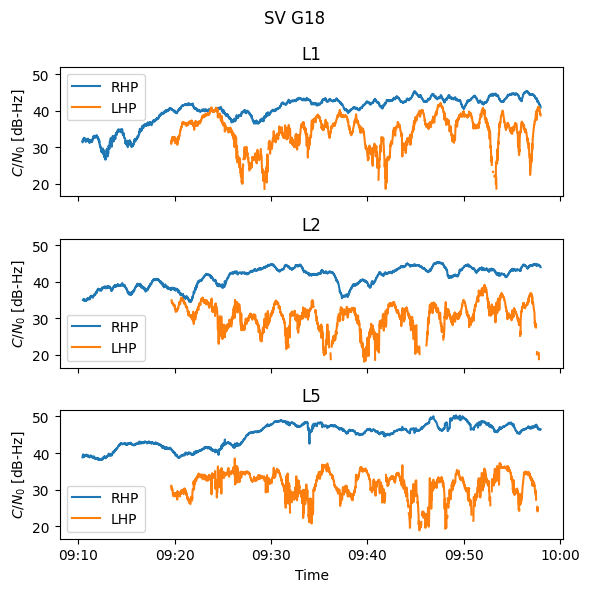

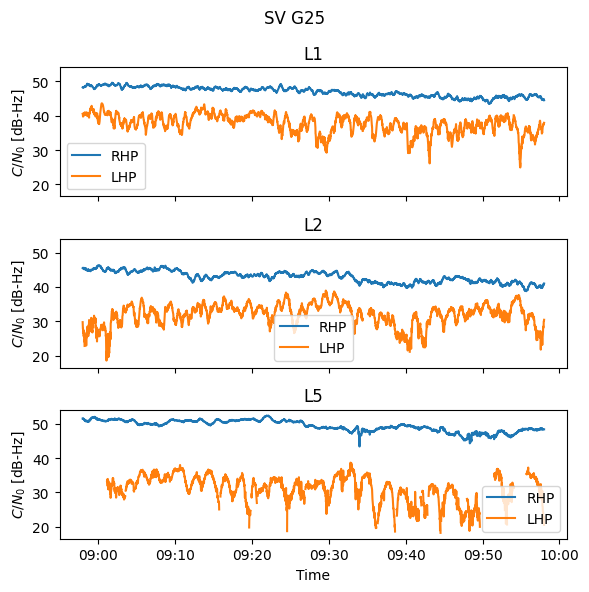

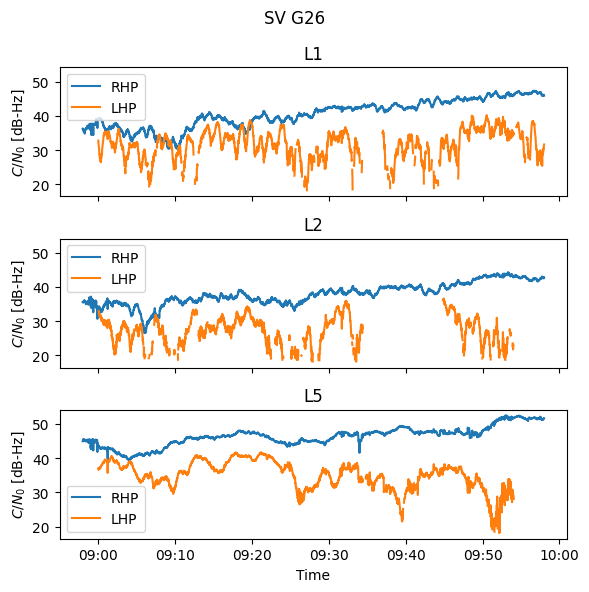

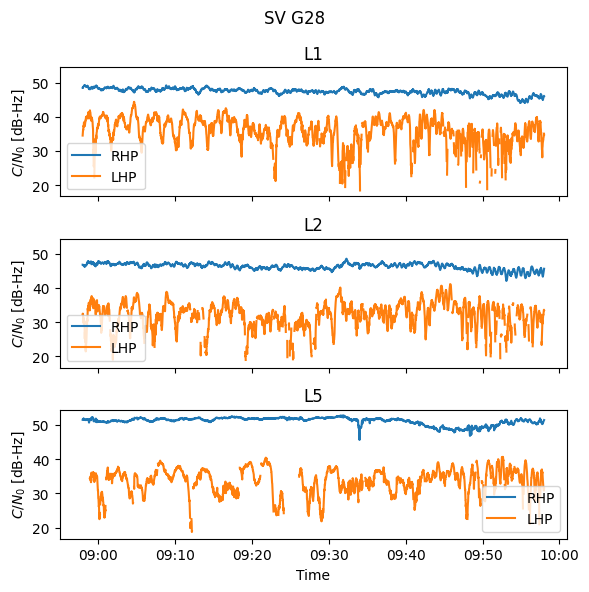

In [174]:
print(sv_list)
for i, sv in enumerate(sv_list):
    cn0_L1_main = obs_main.sel(sv=sv)['S1C'].values
    cn0_L2_main = obs_main.sel(sv=sv)['S2L'].values
    cn0_L5_main = obs_main.sel(sv=sv)['S5Q'].values
    cn0_L1_aux = obs_aux.sel(sv=sv)['S1C'].values
    cn0_L2_aux = obs_aux.sel(sv=sv)['S2L'].values
    cn0_L5_aux = obs_aux.sel(sv=sv)['S5Q'].values
    fig,ax = plt.subplots(3,figsize=(6,6),sharex=True,sharey=True)
    fig.suptitle(f'SV {sv}')
    ax[0].plot(obs_main.sel(sv=sv).time.values,cn0_L1_main,label='RHP')
    ax[0].plot(obs_aux.sel(sv=sv).time.values,cn0_L1_aux,label='LHP')
    ax[0].set_ylabel('$C/N_0$ [dB-Hz]')
    ax[0].set_title('L1')
    ax[0].legend(loc='best')
    ax[1].plot(obs_main.sel(sv=sv).time.values,cn0_L2_main,label='RHP')
    ax[1].plot(obs_aux.sel(sv=sv).time.values,cn0_L2_aux,label='LHP')
    ax[1].set_ylabel('$C/N_0$ [dB-Hz]')
    ax[1].set_title('L2')
    ax[1].legend(loc='best')
    ax[2].plot(obs_main.sel(sv=sv).time.values,cn0_L5_main,label='RHP')
    ax[2].plot(obs_aux.sel(sv=sv).time.values,cn0_L5_aux,label='LHP')
    ax[2].set_ylabel('$C/N_0$ [dB-Hz]')
    ax[2].set_xlabel('Time')
    ax[2].set_title('L5')
    ax[2].legend(loc='best')
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.tight_layout()
    plt.savefig(f'../figs/cn0_different_frequencies/GPS/{wall_type}_{date}/GPS_{wall_type}_{sv}_cn0_RHPvLHP_{date}.png')
    plt.savefig(f'../figs/cn0_different_frequencies/GPS/{wall_type}_{date}/GPS_{wall_type}_{sv}_cn0_RHPvLHP_{date}.pdf')
    plt.show()


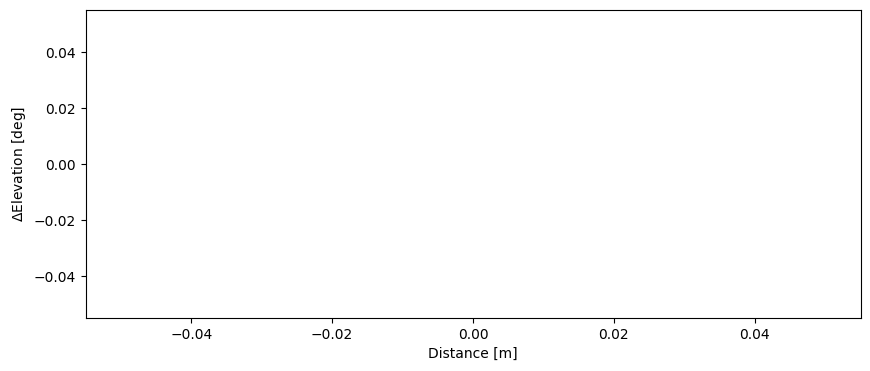

Change in elevation after receiver being moved 1km: nan°


In [ ]:
sv_idx = np.where(sv_list == 'G31')[0]

pos_length = 1000 # m

t = np.int64(np.nanmin(nav_main.Toe.values[0]))

# initialize 
az_wall = np.zeros((len(sv_list),pos_length))
el_wall = np.zeros_like(az_wall)
zen_wall = np.zeros_like(az_wall)
az_receiver = np.zeros_like(az_wall)
el_receiver = np.zeros_like(az_wall)
zen_receiver = np.zeros_like(az_wall)

wall_ecef_pos = ecef_pos.copy()
wall_ecef_pos[0] += 3
receiver_ecef_pos = ecef_pos.copy()

for i in range(pos_length):
    
    receiver_ecef_pos[0] -= 1
    receiver_lla_pos = ecef_to_lla(receiver_ecef_pos[0],receiver_ecef_pos[1],receiver_ecef_pos[2])
    wall_lla_pos = ecef_to_lla(wall_ecef_pos[0],wall_ecef_pos[1],wall_ecef_pos[2])

    R_L_receiver = R1(90-receiver_lla_pos[0])@R3(receiver_lla_pos[1]+90)
    R_L_wall = R1(90-wall_lla_pos[0])@R3(wall_lla_pos[1]+90)
    # calculate satellite positions
    sat_positions, _, _ = calcSatPos(nav_main, t, sv_list)
    for j in range(np.shape(sat_positions)[1]):

        # calculate ENU coordinates of satellite
        sat_ENU_receiver = (R_L_receiver @ (sat_positions[:,j].reshape((-1,1)) - receiver_ecef_pos.reshape((-1,1)).T))
        sat_ENU_receiver = sat_ENU_receiver[:,0]
        sat_ENU_wall = (R_L_wall @ (sat_positions[:,j].reshape((-1,1)) - wall_ecef_pos.reshape((-1,1)).T))
        sat_ENU_wall = sat_ENU_wall[:,0]

        # calculate azimuth and zenith for wall
        azimuth_wall = np.arctan2(sat_ENU_wall[0], sat_ENU_wall[1]) * 180 / np.pi
        zenith_wall = np.arccos(sat_ENU_wall[2] / np.sqrt(sat_ENU_wall[0]**2 + sat_ENU_wall[1]**2 + sat_ENU_wall[2]**2)) * 180 / np.pi 
        # calculate azimuth and zenith for receiver
        azimuth_receiver = np.arctan2(sat_ENU_receiver[0], sat_ENU_receiver[1]) * 180 / np.pi
        zenith_receiver = np.arccos(sat_ENU_receiver[2] / np.sqrt(sat_ENU_receiver[0]**2 + sat_ENU_receiver[1]**2 + sat_ENU_receiver[2]**2)) * 180 / np.pi 

        zen_wall[j] = zenith_wall
        zen_receiver[j] = zenith_receiver

        if azimuth_wall < 0:
            azimuth_wall = 360 + azimuth_wall
        if azimuth_receiver < 0:
            azimuth_receiver = 360 + azimuth_receiver
        
        if ((90-zenith_wall) > 0):
            az_wall[j,i] = azimuth_wall
            el_wall[j,i] = 90-zenith_wall
        else:
            az_wall[j,i] = np.nan
            el_wall[j,i] = np.nan

        if ((90-zenith_receiver) > 0):
            az_receiver[j,i] = azimuth_receiver
            el_receiver[j,i] = 90-zenith_receiver
        else:
            az_receiver[j,i] = np.nan
            el_receiver[j,i] = np.nan

plt.figure(figsize=(10,4))
plt.plot(el_receiver[sv_idx][0]-el_wall[sv_idx][0])
plt.xlabel('Distance [m]')
plt.ylabel(f'$\Delta$Elevation [deg]')
plt.show()

delta_el = el_receiver[sv_idx][0][-1]-el_receiver[sv_idx][0][0]
print(f'Change in elevation after receiver being moved 1km: {delta_el}\u00b0')

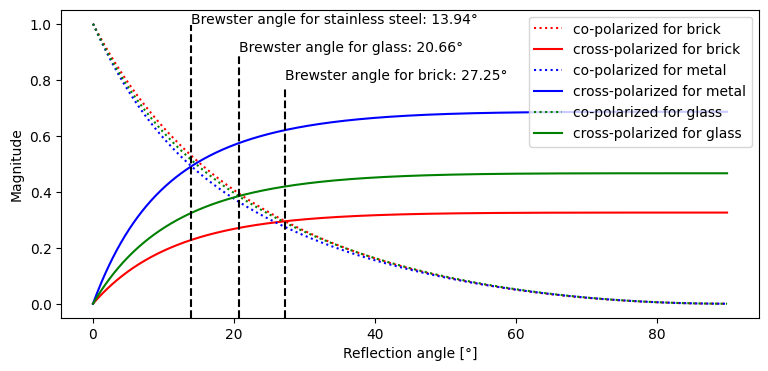

In [9]:
freq_L1 = 10.23e06 * 154 # Hz
freq_L2 = 10.23e06 * 120 # Hz
freq_L5 = 10.23e06 * 115 # Hz
c = 299792458 # m/s

elevation = np.linspace(0,90,180*2**4+1)

def reflection_perpendicular(elevation,Y):

    result = np.cos(elevation) - np.sqrt(Y - np.sin(elevation)**2) 
    result /= np.cos(elevation) + np.sqrt(Y - np.sin(elevation)**2)
    return result

def reflection_parallel(elevation,Y):

    result = Y * np.cos(elevation) - np.sqrt(Y - np.sin(elevation)**2) 
    result /= Y * np.cos(elevation) + np.sqrt(Y - np.sin(elevation)**2)
    return result

def get_Y(relative_permittivity, wavelength, conductivity):
    return relative_permittivity - 1j*60*wavelength*conductivity

def copolarized_component(elevation,Y):
    R_co = reflection_perpendicular(elevation,Y) + reflection_parallel(elevation,Y)
    R_co /= 2
    return R_co

def crosspolarized_component(elevation,Y):
    R_cross = reflection_perpendicular(elevation,Y) - reflection_parallel(elevation,Y)
    R_cross /= 2
    return R_cross

relative_permittivity_brick = 3.56 # from relative_permittivty_conductivity article
conductivity_brick = 9.46e-2 # from relative_permittivty_conductivity article
relative_permittivity_metal = 2 # https://www.quora.com/What-is-the-permittivity-of-steel
conductivity_metal = 1.33 # https://www.leoni-wire-products-solutions.com/en/materials/conductor-materials/stainless-steel/
relative_permittivity_glass = 5.98 # from relative_permittivty_conductivity article
conductivity_glass = 2.99e-1 # from relative_permittivty_conductivity article

Y_brick = get_Y(relative_permittivity_brick,c/freq_L1,conductivity_brick)
Y_metal = get_Y(relative_permittivity_metal,c/freq_L1,conductivity_metal)
Y_glass = get_Y(relative_permittivity_glass,c/freq_L1,conductivity_glass)

def find_brewster_angle(copolarized_component,crosspolarized_component,elevation):
    idx = np.where(np.abs(copolarized_component) > np.abs(crosspolarized_component))[0]
    return elevation[idx[-1]]

plt.figure(figsize=(9,4))
plt.plot(elevation,np.abs(copolarized_component(np.deg2rad(90 - elevation), Y_brick)),color='red',linestyle=':',label=f'co-polarized for brick')
plt.plot(elevation,np.abs(crosspolarized_component(np.deg2rad(90 - elevation), Y_brick)),color='red',label=f'cross-polarized for brick')
plt.plot(elevation,np.abs(copolarized_component(np.deg2rad(90 - elevation), Y_metal)),color='blue',linestyle=':',label=f'co-polarized for metal')
plt.plot(elevation,np.abs(crosspolarized_component(np.deg2rad(90 - elevation), Y_metal)),color='blue',label=f'cross-polarized for metal')
plt.plot(elevation,np.abs(copolarized_component(np.deg2rad(90 - elevation), Y_glass)),color='green',linestyle=':',label=f'co-polarized for glass')
plt.plot(elevation,np.abs(crosspolarized_component(np.deg2rad(90 - elevation), Y_glass)),color='green',label=f'cross-polarized for glass')

plt.axvline(x=find_brewster_angle(np.abs(copolarized_component(np.deg2rad(90 - elevation), Y_brick)), 
                                  np.abs(crosspolarized_component(np.deg2rad(90 - elevation), Y_brick)), 
                                  elevation), color='black', linestyle='--', ymax=0.75)
plt.axvline(x=find_brewster_angle(np.abs(copolarized_component(np.deg2rad(90 - elevation), Y_metal)), 
                                  np.abs(crosspolarized_component(np.deg2rad(90 - elevation), Y_metal)), 
                                  elevation), color='black', linestyle='--', ymax=0.95)
plt.axvline(x=find_brewster_angle(np.abs(copolarized_component(np.deg2rad(90 - elevation), Y_glass)), 
                                  np.abs(crosspolarized_component(np.deg2rad(90 - elevation), Y_glass)), 
                                  elevation), color='black', linestyle='--', ymax=0.85)
plt.annotate(f'Brewster angle for stainless steel: {find_brewster_angle(np.abs(copolarized_component(np.deg2rad(90 - elevation), Y_metal)), np.abs(crosspolarized_component(np.deg2rad(90 - elevation), Y_metal)), elevation):.2f}°', 
             xy=(find_brewster_angle(np.abs(copolarized_component(np.deg2rad(90 - elevation), Y_metal)), 
                                     np.abs(crosspolarized_component(np.deg2rad(90 - elevation), Y_metal)), 
                                     elevation), 1))
plt.annotate(f'Brewster angle for brick: {find_brewster_angle(np.abs(copolarized_component(np.deg2rad(90 - elevation), Y_brick)), np.abs(crosspolarized_component(np.deg2rad(90 - elevation), Y_brick)), elevation):.2f}°', 
             xy=(find_brewster_angle(np.abs(copolarized_component(np.deg2rad(90 - elevation), Y_brick)), 
                                     np.abs(crosspolarized_component(np.deg2rad(90 - elevation), Y_brick)), 
                                     elevation), 0.8))
plt.annotate(f'Brewster angle for glass: {find_brewster_angle(np.abs(copolarized_component(np.deg2rad(90 - elevation), Y_glass)), np.abs(crosspolarized_component(np.deg2rad(90 - elevation), Y_glass)), elevation):.2f}°', 
             xy=(find_brewster_angle(np.abs(copolarized_component(np.deg2rad(90 - elevation), Y_glass)), 
                                     np.abs(crosspolarized_component(np.deg2rad(90 - elevation), Y_glass)), 
                                     elevation), 0.9))
plt.legend(loc='upper right')
plt.ylabel('Magnitude')
plt.xlabel('Reflection angle [°]')
plt.savefig(f'../figs/Brewster_angles_used_materials.png')
plt.savefig(f'../figs/Brewster_angles_used_materials.pdf')
plt.show()



In [106]:
elevation_Brewster_metal = 90 - 13.94
elevation_Brewster_glass = 90 - 20.66
elevation_Brewster_brick = 90 - 27.25

print(elevation_Brewster_brick)
print(elevation_Brewster_glass)
print(elevation_Brewster_metal)

62.75
69.34
76.06


In [3]:
path_metal = f'../Data/metal_wall/distance_correlations/'
path_glass = f'../Data/glass_wall/distance_correlations/'
path_brick = f'../Data/brick_wall/distance_correlations/'

metal_date = f'020524'
metal_short = f'{metal_date}/3631751_metal_diff_distance_2.5m'
metal_medium = f'{metal_date}/3632777_metal_diff_distance_5m'
metal_long = f'{metal_date}/3633416_metal_diff_distance_10m'

brick_date = f'210424'
brick_short = f'{brick_date}/3631751_brick_diff_dist_2.5m'
brick_medium = f'{brick_date}/3633416_brick_diff_dist_5m'
brick_long = f'{brick_date}/3632777_brick_diff_dist_10m'

glass_date = f'210424'
glass_short = f'{glass_date}/3631751_glass_diff_dist_2.5m'
glass_medium = f'{glass_date}/3632777_glass_diff_dist_5m'
glass_long = f'{glass_date}/3633416_glass_diff_dist_10m'

use = 'E'

if use == 'G':
    nav = f'_gps.nav'
elif use == 'E':
    nav = f'_galileo.nav'

obs_metal_short = gr.load(f'{path_metal}{metal_short}.obs',use=use)
obs_metal_medium = gr.load(f'{path_metal}{metal_medium}.obs',use=use)
obs_metal_long = gr.load(f'{path_metal}{metal_long}.obs',use=use)

obs_brick_short = gr.load(f'{path_brick}{brick_short}.obs',use=use)
obs_brick_medium = gr.load(f'{path_brick}{brick_medium}.obs',use=use)
obs_brick_long = gr.load(f'{path_brick}{brick_long}.obs',use=use)

obs_glass_short = gr.load(f'{path_glass}{glass_short}.obs',use=use)
obs_glass_medium = gr.load(f'{path_glass}{glass_medium}.obs',use=use)
obs_glass_long = gr.load(f'{path_glass}{glass_long}.obs',use=use)

nav_metal_short = gr.load(f'{path_metal}{metal_short}{nav}')
nav_metal_medium = gr.load(f'{path_metal}{metal_medium}{nav}')
nav_metal_long = gr.load(f'{path_metal}{metal_long}{nav}')

nav_brick_short = gr.load(f'{path_brick}{brick_short}{nav}')
nav_brick_medium = gr.load(f'{path_brick}{brick_medium}{nav}')
nav_brick_long = gr.load(f'{path_brick}{brick_long}{nav}')

nav_glass_short = gr.load(f'{path_glass}{glass_short}{nav}')
nav_glass_medium = gr.load(f'{path_glass}{glass_medium}{nav}')
nav_glass_long = gr.load(f'{path_glass}{glass_long}{nav}')

In [4]:
CN0_L1_SELECTOR = 'S1C'
CN0_L2_SELECTOR = 'S2L'
CN0_L5_SELECTOR = 'S5Q'
CN0_E1_SELECTOR = "S1C"
CN0_E5A_SELECTOR = "S5Q"
CN0_E5B_SELECTOR = "S7Q"
CN0_E5AB_SELECTOR = "S8Q"

def moving_average(arr, window_size=50):
    padded_arr = np.pad(arr, (window_size // 2, window_size // 2), mode='edge')
    cumsum = np.cumsum(padded_arr)
    moving_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    return moving_avg

def normalize_amplitude_timeseries(data):
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)

    normalized_data = (data - np.nanmean(data))/(max_val - min_val)

    return normalized_data

def get_common_sv_list(obs_short,obs_medium,obs_long):
    sv_list_short = obs_short.sv.values
    sv_list_medium = obs_medium.sv.values
    sv_list_long = obs_long.sv.values

    sv_list = [sv for sv in sv_list_long if sv in sv_list_short and sv in sv_list_medium]

    return sv_list 

def get_spectrogram_all_bands(obs,sv,use='G',normalize=True,use_moving_average=True,window_size=14,window='blackmanharris',nperseg=1300,nfft=2400,noverlap=1200,spectrum='spectrum',mode='psd'):
    CN0_L1_SELECTOR = 'S1C'
    CN0_L2_SELECTOR = 'S2L'
    CN0_L5_SELECTOR = 'S5Q'
    CN0_E1_SELECTOR = "S1C"
    CN0_E5A_SELECTOR = "S5Q"
    CN0_E5B_SELECTOR = "S7Q"
    CN0_E5AB_SELECTOR = "S8Q"

    if use=='G':
        L1_cn0 = obs.sel(sv=sv)[CN0_L1_SELECTOR]
        L2_cn0 = obs.sel(sv=sv)[CN0_L2_SELECTOR]
        L5_cn0 = obs.sel(sv=sv)[CN0_L5_SELECTOR]

        if normalize:
            L1_cn0 = normalize_amplitude_timeseries(L1_cn0)
            L2_cn0 = normalize_amplitude_timeseries(L2_cn0)
            L5_cn0 = normalize_amplitude_timeseries(L5_cn0)
        if use_moving_average:
            L1_cn0 = moving_average(L1_cn0,window_size=window_size)
            L2_cn0 = moving_average(L2_cn0,window_size=window_size)
            L5_cn0 = moving_average(L5_cn0,window_size=window_size)

        f, t, Sxx_L1 = signal.spectrogram(L1_cn0, fs = 1, 
                                          window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap,
                                          scaling=spectrum, mode=mode)
        _, _, Sxx_L2 = signal.spectrogram(L2_cn0, fs = 1, 
                                          window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap,
                                          scaling=spectrum, mode=mode)
        _, _, Sxx_L5 = signal.spectrogram(L5_cn0, fs = 1, 
                                          window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap,
                                          scaling=spectrum, mode=mode)
        return f, t, Sxx_L1, Sxx_L2, Sxx_L5
    
    elif use=='E':
        E1_cn0 = obs.sel(sv=sv)[CN0_E1_SELECTOR]
        E5a_cn0 = obs.sel(sv=sv)[CN0_E5A_SELECTOR]
        E5b_cn0 = obs.sel(sv=sv)[CN0_E5B_SELECTOR]
        E5ab_cn0 = obs.sel(sv=sv)[CN0_E5AB_SELECTOR]

        if normalize:
            E1_cn0 = normalize_amplitude_timeseries(E1_cn0)
            E5a_cn0 = normalize_amplitude_timeseries(E5a_cn0)
            E5b_cn0 = normalize_amplitude_timeseries(E5b_cn0)
            E5ab_cn0 = normalize_amplitude_timeseries(E5ab_cn0)
        if moving_average:
            E1_cn0 = moving_average(E1_cn0,window_size=window_size)
            E5a_cn0 = moving_average(E5a_cn0,window_size=window_size)
            E5b_cn0 = moving_average(E5b_cn0,window_size=window_size)
            E5ab_cn0 = moving_average(E5ab_cn0,window_size=window_size)

        f, t, Sxx_E1 = signal.spectrogram(E1_cn0, fs = 1, 
                                          window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap,
                                          scaling=spectrum, mode=mode)
        _, _, Sxx_E5a = signal.spectrogram(E5a_cn0, fs = 1, 
                                          window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap,
                                          scaling=spectrum, mode=mode)
        _, _, Sxx_E5b = signal.spectrogram(E5b_cn0, fs = 1, 
                                          window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap,
                                          scaling=spectrum, mode=mode)
        _, _, Sxx_E5ab = signal.spectrogram(E5ab_cn0, fs = 1, 
                                          window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap,
                                          scaling=spectrum, mode=mode)
        return f, t, Sxx_E1, Sxx_E5a, Sxx_E5b, Sxx_E5ab


def interpolate_image(image, scale_factor):
    # Get the dimensions of the original image
    height, width, channels = image.shape
    
    # Define the new dimensions after scaling
    new_height = int(height * scale_factor)
    new_width = int(width * scale_factor)
    
    # Generate the indices for the new image
    x_new = np.linspace(0, width - 1, new_width)
    y_new = np.linspace(0, height - 1, new_height)
    
    # Generate the grid for the interpolation
    x_old = np.arange(width)
    y_old = np.arange(height)
    
    # Perform bilinear interpolation for each channel
    interpolated_image = np.zeros((new_height, new_width, channels))
    for c in range(channels):
        interpolator = RectBivariateSpline(y_old, x_old, image[:,:,c])
        interpolated_channel = interpolator(y_new, x_new)

        # Normalize the interpolated channel to match the original image's range
        min_val = np.min(image[:,:,c])
        max_val = np.max(image[:,:,c])
        
        interpolated_channel = (interpolated_channel - np.min(interpolated_channel)) * (max_val - min_val) / (np.max(interpolated_channel) - np.min(interpolated_channel)) + min_val
        
        interpolated_image[:,:,c] = interpolated_channel
    
    return interpolated_image

In [5]:
sv_list_metal = get_common_sv_list(obs_metal_short,obs_metal_medium,obs_metal_long)
sv_list_brick = get_common_sv_list(obs_brick_short,obs_brick_medium,obs_brick_long)
sv_list_glass = get_common_sv_list(obs_glass_short,obs_glass_medium,obs_glass_long)

print(sv_list_metal)
print(sv_list_glass)
print(sv_list_brick)

interesting_sv_metal_gps = 'G28' 
interesting_sv_glass_gps = 'G26'
interesting_sv_brick_gps = 'G11'

interesting_sv_metal_gal = 'E24' # E24 E05 E03
interesting_sv_glass_gal = 'E30' # E27 E30 good candidates
interesting_sv_brick_gal = 'E25'

if use == 'G':
    interesting_sv_metal = interesting_sv_metal_gps
    interesting_sv_brick = interesting_sv_brick_gps
    interesting_sv_glass = interesting_sv_glass_gps
elif use == 'E':
    interesting_sv_metal = interesting_sv_metal_gal
    interesting_sv_brick = interesting_sv_brick_gal
    interesting_sv_glass = interesting_sv_glass_gal

['E03', 'E05', 'E08', 'E09', 'E10', 'E24', 'E25', 'E31']
['E02', 'E13', 'E15', 'E27', 'E30', 'E34']
['E02', 'E10', 'E11', 'E12', 'E25', 'E34', 'E36']


In [6]:
if use == 'G':
    f_brick_short, t_brick_short, Sxx_L1_brick_short, Sxx_L2_brick_short, Sxx_L5_brick_short = get_spectrogram_all_bands(obs_brick_short, interesting_sv_brick, use=use)
    f_brick_medium, t_brick_medium, Sxx_L1_brick_medium, Sxx_L2_brick_medium, Sxx_L5_brick_medium = get_spectrogram_all_bands(obs_brick_medium, interesting_sv_brick, use=use)
    f_brick_long, t_brick_long, Sxx_L1_brick_long, Sxx_L2_brick_long, Sxx_L5_brick_long = get_spectrogram_all_bands(obs_brick_long, interesting_sv_brick, use=use)

    f_metal_short, t_metal_short, Sxx_L1_metal_short, Sxx_L2_metal_short, Sxx_L5_metal_short = get_spectrogram_all_bands(obs_metal_short, interesting_sv_metal, use=use)
    f_metal_medium, t_metal_medium, Sxx_L1_metal_medium, Sxx_L2_metal_medium, Sxx_L5_metal_medium = get_spectrogram_all_bands(obs_metal_medium, interesting_sv_metal, use=use)
    f_metal_long, t_metal_long, Sxx_L1_metal_long, Sxx_L2_metal_long, Sxx_L5_metal_long = get_spectrogram_all_bands(obs_metal_long, interesting_sv_metal, use=use)

    f_glass_short, t_glass_short, Sxx_L1_glass_short, Sxx_L2_glass_short, Sxx_L5_glass_short = get_spectrogram_all_bands(obs_glass_short, interesting_sv_glass, use=use)
    f_glass_medium, t_glass_medium, Sxx_L1_glass_medium, Sxx_L2_glass_medium, Sxx_L5_glass_medium = get_spectrogram_all_bands(obs_glass_medium, interesting_sv_glass, use=use)
    f_glass_long, t_glass_long, Sxx_L1_glass_long, Sxx_L2_glass_long, Sxx_L5_glass_long = get_spectrogram_all_bands(obs_glass_long, interesting_sv_glass, use=use)
elif use == 'E':
    f_brick_short, t_brick_short, Sxx_E1_brick_short, Sxx_E5a_brick_short, Sxx_E5b_brick_short, Sxx_E5ab_brick_short = get_spectrogram_all_bands(obs_brick_short, interesting_sv_brick, use=use)
    f_brick_medium, t_brick_medium, Sxx_E1_brick_medium, Sxx_E5a_brick_medium, Sxx_E5b_brick_medium, Sxx_E5ab_brick_medium = get_spectrogram_all_bands(obs_brick_medium, interesting_sv_brick, use=use)
    f_brick_long, t_brick_long, Sxx_E1_brick_long, Sxx_E5a_brick_long, Sxx_E5b_brick_long, Sxx_E5ab_brick_long = get_spectrogram_all_bands(obs_brick_long, interesting_sv_brick, use=use)

    f_metal_short, t_metal_short, Sxx_E1_metal_short, Sxx_E5a_metal_short, Sxx_E5b_metal_short, Sxx_E5ab_metal_short = get_spectrogram_all_bands(obs_metal_short, interesting_sv_metal, use=use)
    f_metal_medium, t_metal_medium, Sxx_E1_metal_medium, Sxx_E5a_metal_medium, Sxx_E5b_metal_medium, Sxx_E5ab_metal_medium = get_spectrogram_all_bands(obs_metal_medium, interesting_sv_metal, use=use)
    f_metal_long, t_metal_long, Sxx_E1_metal_long, Sxx_E5a_metal_long, Sxx_E5b_metal_long, Sxx_E5ab_metal_long = get_spectrogram_all_bands(obs_metal_long, interesting_sv_metal, use=use)

    f_glass_short, t_glass_short, Sxx_E1_glass_short, Sxx_E5a_glass_short, Sxx_E5b_glass_short, Sxx_E5ab_glass_short = get_spectrogram_all_bands(obs_glass_short, interesting_sv_glass, use=use)
    f_glass_medium, t_glass_medium, Sxx_E1_glass_medium, Sxx_E5a_glass_medium, Sxx_E5b_glass_medium, Sxx_E5ab_glass_medium = get_spectrogram_all_bands(obs_glass_medium, interesting_sv_glass, use=use)
    f_glass_long, t_glass_long, Sxx_E1_glass_long, Sxx_E5a_glass_long, Sxx_E5b_glass_long, Sxx_E5ab_glass_long = get_spectrogram_all_bands(obs_glass_long, interesting_sv_glass, use=use)



In [7]:
# normalize everything

materials = ["brick", "metal", "glass"]
distances = ["short", "medium", "long"]

global_min_values = []
global_max_values = []

if use == 'G':
    frequencies = ["L1", "L2", "L5"]
    
    for frequency in frequencies:
        for material in materials:
            for distance in distances:
                global_min_values.append(np.min(eval(f"Sxx_{frequency}_{material}_{distance}")))
                global_max_values.append(np.max(eval(f"Sxx_{frequency}_{material}_{distance}")))
elif use == 'E':
    frequencies = ["E1", "E5a", "E5b", "E5ab"]
    
    for frequency in frequencies:
        for material in materials:
            for distance in distances:
                global_min_values.append(np.min(eval(f"Sxx_{frequency}_{material}_{distance}")))
                global_max_values.append(np.max(eval(f"Sxx_{frequency}_{material}_{distance}")))

global_min_value = min(global_min_values)
global_max_value = max(global_max_values)

if use == 'G':
    frequencies = ["L1", "L2", "L5"]

    for frequency in frequencies:
        for material in materials:
            for distance in distances:
                exec(f"Sxx_{frequency}_{material}_{distance}_normalized = (Sxx_{frequency}_{material}_{distance} - global_min_value) / (global_max_value - global_min_value)")
elif use == 'E':
    frequencies = ["E1", "E5a", "E5b", "E5ab"]

    for frequency in frequencies:
        for material in materials:
            for distance in distances:
                exec(f"Sxx_{frequency}_{material}_{distance}_normalized = (Sxx_{frequency}_{material}_{distance} - global_min_value) / (global_max_value - global_min_value)")

In [151]:
# normalizing per image (frequency images)

materials = ["brick", "metal", "glass"]
distances = ["short", "medium", "long"]

global_min_values = []
global_max_values = []

if use == 'G':
    frequencies = ["L1", "L2", "L5"]
    
    for distance in distances:
        for material in materials:
            min_values = []
            max_values = []
            for frequency in frequencies:
                min_values.append(np.min(eval(f"Sxx_{frequency}_{material}_{distance}")))
                max_values.append(np.max(eval(f"Sxx_{frequency}_{material}_{distance}")))
            Sxx_min = min(min_values)
            Sxx_max = max(max_values)
            for frequency in frequencies:
                exec(f"Sxx_{frequency}_{material}_{distance}_normalized = (Sxx_{frequency}_{material}_{distance} - Sxx_min) / (Sxx_max - Sxx_min)")
elif use == 'E':
    frequencies = ["E1", "E5a", "E5b", "E5ab"]
    
    for distance in distances:
        for material in materials:
            min_values = []
            max_values = []
            for frequency in frequencies:
                min_values.append(np.min(eval(f"Sxx_{frequency}_{material}_{distance}")))
                max_values.append(np.max(eval(f"Sxx_{frequency}_{material}_{distance}")))
            Sxx_min = min(min_values)
            Sxx_max = max(max_values)
            for frequency in frequencies:
                exec(f"Sxx_{frequency}_{material}_{distance}_normalized = (Sxx_{frequency}_{material}_{distance} - Sxx_min) / (Sxx_max - Sxx_min)")


In [146]:
# normalizing per image (distance images)

materials = ["brick", "metal", "glass"]
distances = ["short", "medium", "long"]

global_min_values = []
global_max_values = []

if use == 'G':
    frequencies = ["L1", "L2", "L5"]
    
    for frequency in frequencies:
        for material in materials:
            min_values = []
            max_values = []
            for distance in distances:
                min_values.append(np.min(eval(f"Sxx_{frequency}_{material}_{distance}")))
                max_values.append(np.max(eval(f"Sxx_{frequency}_{material}_{distance}")))
            Sxx_min = min(min_values)
            Sxx_max = max(max_values)
            for distance in distances:
                exec(f"Sxx_{frequency}_{material}_{distance}_normalized = (Sxx_{frequency}_{material}_{distance} - Sxx_min) / (Sxx_max - Sxx_min)")
elif use == 'E':
    frequencies = ["E1", "E5a", "E5b", "E5ab"]
    
    for frequency in frequencies:
        for material in materials:
            min_values = []
            max_values = []
            for distance in distances:
                min_values.append(np.min(eval(f"Sxx_{frequency}_{material}_{distance}")))
                max_values.append(np.max(eval(f"Sxx_{frequency}_{material}_{distance}")))
            Sxx_min = min(min_values)
            Sxx_max = max(max_values)
            for distance in distances:
                exec(f"Sxx_{frequency}_{material}_{distance}_normalized = (Sxx_{frequency}_{material}_{distance} - Sxx_min) / (Sxx_max - Sxx_min)")


In [180]:
# normalizing per material

materials = ["brick", "metal", "glass"]
distances = ["short", "medium", "long"]

if use == 'G':
    frequencies = ["L1", "L2", "L5"]
elif use == 'E':
    frequencies = ["E1", "E5a", "E5b", "E5ab"]

for material in materials:
    # Initialize lists to store min and max values for each frequency
    min_values = []
    max_values = []

    # Compute min and max values for each combination of material and distance
    for frequency in frequencies:
        for distance in distances:
            sxx = eval(f"Sxx_{frequency}_{material}_{distance}")
            min_values.append(np.min(sxx))
            max_values.append(np.max(sxx))

    # Compute global min and max for this frequency
    global_min_value = min(min_values)
    global_max_value = max(max_values)

    # Normalize Sxx values for each combination of frequency and distance
    for frequency in frequencies:
        for distance in distances:
            sxx = eval(f"Sxx_{frequency}_{material}_{distance}")
            exec(f"Sxx_{frequency}_{material}_{distance}_normalized = (sxx - global_min_value) / (global_max_value - global_min_value)")


In [8]:
materials = ['brick', 'metal', 'glass']

if use == 'G':
    frequencies = ['L1', 'L2', 'L5']

    for frequency in frequencies:
        for material in materials:
            exec(f"rgb_image_{frequency}_{material} = np.stack((Sxx_{frequency}_{material}_short_normalized, Sxx_{frequency}_{material}_medium_normalized, Sxx_{frequency}_{material}_long_normalized),axis=-1)")
elif use == 'E':
    frequencies = ['E1', 'E5a', 'E5b', 'E5ab']

    for frequency in frequencies:
        for material in materials:
            exec(f"rgb_image_{frequency}_{material} = np.stack((Sxx_{frequency}_{material}_short_normalized, Sxx_{frequency}_{material}_medium_normalized, Sxx_{frequency}_{material}_long_normalized),axis=-1)")

In [9]:
materials = ["brick", "metal", "glass"]
ylim_min = 0  # Lower y-limit
ylim_max = 0.025  # Upper y-limit

if use == 'G':
    frequencies = ["L1", "L2", "L5"]

    # Loop through each image category and level
    for material in materials:
        for frequency in frequencies:
            # Access the corresponding RGB image variable
            rgb_image = globals()[f"rgb_image_{frequency}_{material}"]
            
            # Calculate crop indices
            num_rows = rgb_image.shape[0]
            crop_min = int(ylim_min * num_rows)
            crop_max = int(ylim_max * num_rows)
            
            # Crop the image
            globals()[f"rgb_image_{frequency}_{material}"] = rgb_image[crop_min:crop_max, :, :]
elif use == 'E':
    frequencies = ["E1", "E5a", "E5b", "E5ab"]

    # Loop through each image category and level
    for material in materials:
        for frequency in frequencies:
            # Access the corresponding RGB image variable
            rgb_image = globals()[f"rgb_image_{frequency}_{material}"]
            
            # Calculate crop indices
            num_rows = rgb_image.shape[0]
            crop_min = int(ylim_min * num_rows)
            crop_max = int(ylim_max * num_rows)
            
            # Crop the image
            globals()[f"rgb_image_{frequency}_{material}"] = rgb_image[crop_min:crop_max, :, :]


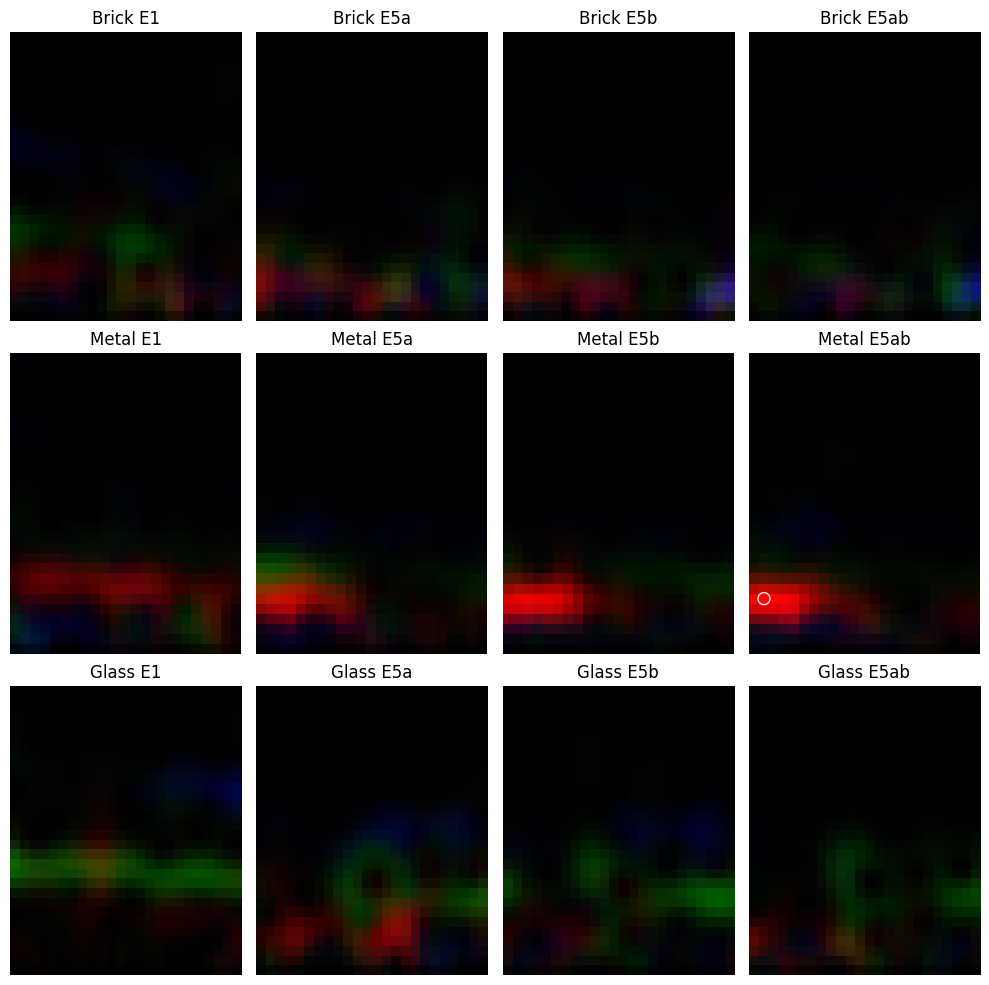

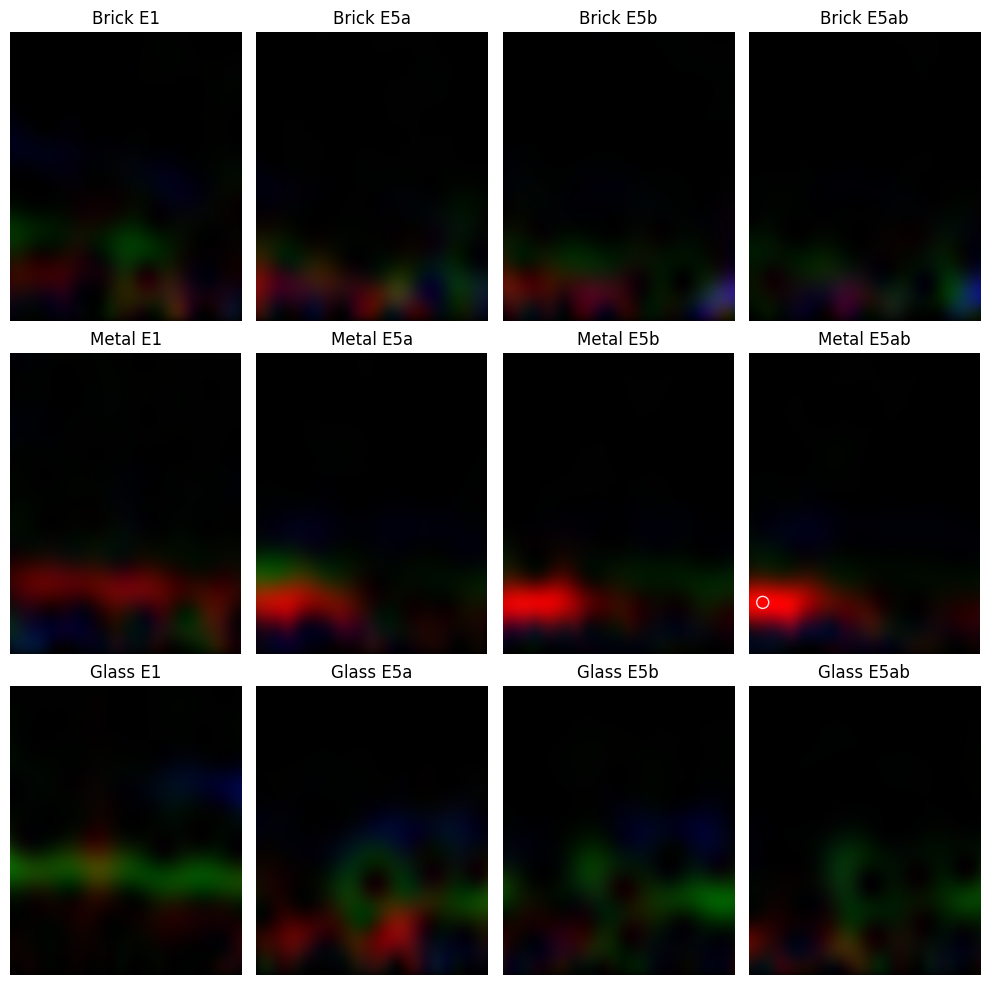

In [10]:
def plot_image_with_max(rgb_image, ax, title, find_max=False, interpolate=False):
    if interpolate:
        scale_factor = 4
        rgb_image = interpolate_image(rgb_image,scale_factor)
    ax.imshow(rgb_image)
    if find_max:
        rgb_sum = np.sum(rgb_image, axis=2)
        max_value = np.max(rgb_sum)
        if max_value >= 1:
            max_idx = np.unravel_index(np.argmax(rgb_sum), rgb_sum.shape)
            ax.scatter(max_idx[1], max_idx[0], s=75, alpha=0.9, color='white', marker='o', facecolors='none')
    ax.invert_yaxis()
    ax.set_title(title)
    ax.axis('off')

if use == 'G':
    fig, ax = plt.subplots(3, 3, figsize=(10, 10))

    images = {
        'brick': [rgb_image_L1_brick, rgb_image_L2_brick, rgb_image_L5_brick],
        'metal': [rgb_image_L1_metal, rgb_image_L2_metal, rgb_image_L5_metal],
        'glass': [rgb_image_L1_glass, rgb_image_L2_glass, rgb_image_L5_glass]
    }

    for i, (material, material_images) in enumerate(images.items()):
        for j, image in enumerate(material_images):
            plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {frequencies[j]}',find_max=True)

    plt.tight_layout()
    plt.show()


    fig, ax = plt.subplots(3, 3, figsize=(10, 10))

    images = {
        'brick': [rgb_image_L1_brick, rgb_image_L2_brick, rgb_image_L5_brick],
        'metal': [rgb_image_L1_metal, rgb_image_L2_metal, rgb_image_L5_metal],
        'glass': [rgb_image_L1_glass, rgb_image_L2_glass, rgb_image_L5_glass]
    }

    for i, (material, material_images) in enumerate(images.items()):
        for j, image in enumerate(material_images):
            plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {frequencies[j]}',find_max=True, interpolate=True)

    plt.tight_layout()
    plt.show()
elif use == 'E':
    fig, ax = plt.subplots(3, 4, figsize=(10, 10))

    images = {
        'brick': [rgb_image_E1_brick, rgb_image_E5a_brick, rgb_image_E5b_brick, rgb_image_E5ab_brick],
        'metal': [rgb_image_E1_metal, rgb_image_E5a_metal, rgb_image_E5b_metal, rgb_image_E5ab_metal],
        'glass': [rgb_image_E1_glass, rgb_image_E5a_glass, rgb_image_E5b_glass, rgb_image_E5ab_glass]
    }

    for i, (material, material_images) in enumerate(images.items()):
        for j, image in enumerate(material_images):
            plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {frequencies[j]}',find_max=True)

    plt.tight_layout()
    plt.show()


    fig, ax = plt.subplots(3, 4, figsize=(10, 10))

    images = {
        'brick': [rgb_image_E1_brick, rgb_image_E5a_brick, rgb_image_E5b_brick, rgb_image_E5ab_brick],
        'metal': [rgb_image_E1_metal, rgb_image_E5a_metal, rgb_image_E5b_metal, rgb_image_E5ab_metal],
        'glass': [rgb_image_E1_glass, rgb_image_E5a_glass, rgb_image_E5b_glass, rgb_image_E5ab_glass]
    }

    for i, (material, material_images) in enumerate(images.items()):
        for j, image in enumerate(material_images):
            plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {frequencies[j]}',find_max=True, interpolate=True)

    plt.tight_layout()
    plt.show()



In [188]:
materials = ['brick', 'metal', 'glass']
distances = ['short', 'medium', 'long']

if use == 'G':
    frequencies = ['L1', 'L2', 'L5']

    for distance in distances:
        for material in materials:
            exec(f"rgb_image_{material}_{distance} = np.stack((Sxx_L1_{material}_{distance}_normalized, Sxx_L2_{material}_{distance}_normalized, Sxx_L5_{material}_{distance}_normalized), axis=-1)")
elif use == 'E':
    frequencies = ['E1', 'E5a', 'E5b', 'E5ab']
    color1 = np.array([1, 1, 0])  # Yellow
    color2 = np.array([0, 1, 1])  # Cyan
    color3 = np.array([1, 0, 1])  # Magenta
    color4 = np.array([0.5, 0.5, 0.5])  # Gray

    for distance in distances:
        for material in materials:
            exec(f"height, width = Sxx_E1_{material}_{distance}_normalized.shape")
            exec(f"cmyk_image_{material}_{distance} = np.zeros((height, width, 3))")
            exec(f"cmyk_image_{material}_{distance} += Sxx_E1_{material}_{distance}_normalized[..., np.newaxis] * color1")
            exec(f"cmyk_image_{material}_{distance} += Sxx_E5a_{material}_{distance}_normalized[..., np.newaxis] * color2")
            exec(f"cmyk_image_{material}_{distance} += Sxx_E5b_{material}_{distance}_normalized[..., np.newaxis] * color3")
            exec(f"cmyk_image_{material}_{distance} += Sxx_E5ab_{material}_{distance}_normalized[..., np.newaxis] * color4")
            exec(f"cmyk_image_{material}_{distance} = np.clip(cmyk_image_{material}_{distance}, 0, 1)")


In [189]:
materials = ["brick", "metal", "glass"]
distances = ["short", "medium", "long"]
ylim_min = 0  # Lower y-limit
ylim_max = 0.025  # Upper y-limit

if use == 'G':

    # Loop through each image category and level
    for material in materials:
        for distance in distances:
            # Access the corresponding RGB image variable
            rgb_image = globals()[f"rgb_image_{material}_{distance}"]
            
            # Calculate crop indices
            num_rows = rgb_image.shape[0]
            crop_min = int(ylim_min * num_rows)
            crop_max = int(ylim_max * num_rows)
            
            # Crop the image
            globals()[f"rgb_image_{material}_{distance}"] = rgb_image[crop_min:crop_max, :, :]
elif use == 'E':

    # Loop through each image category and level
    for material in materials:
        for distance in distances:
            # Access the corresponding RGB image variable
            rgb_image = globals()[f"cmyk_image_{material}_{distance}"]
            
            # Calculate crop indices
            num_rows = rgb_image.shape[0]
            crop_min = int(ylim_min * num_rows)
            crop_max = int(ylim_max * num_rows)
            
            # Crop the image
            globals()[f"cmyk_image_{material}_{distance}"] = rgb_image[crop_min:crop_max, :, :]


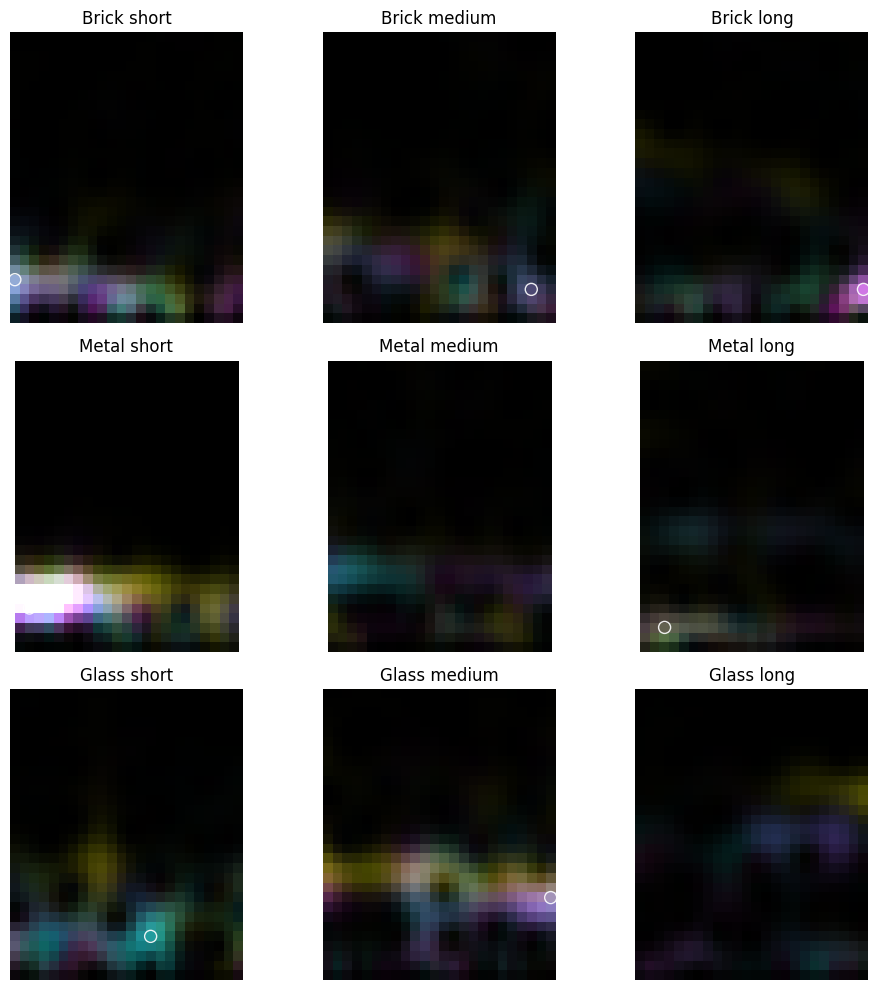

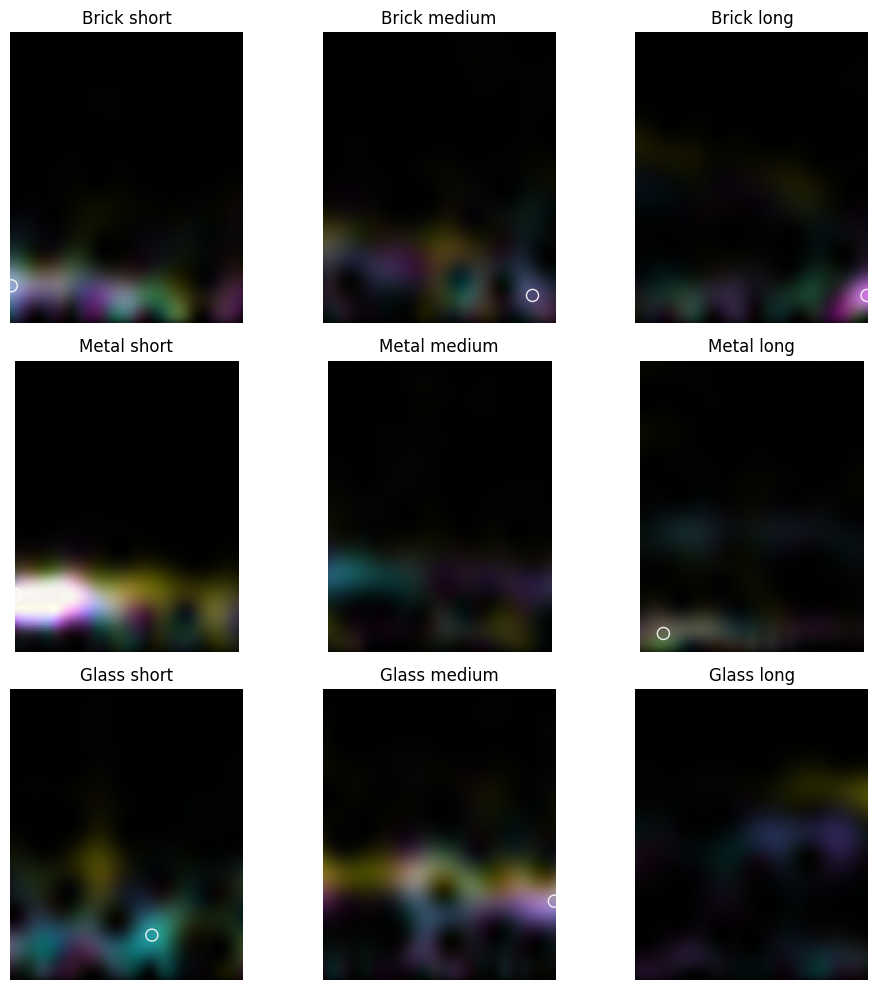

In [190]:

if use == 'G':
    fig, ax = plt.subplots(3, 3, figsize=(10, 10))

    images = {
        'brick': [rgb_image_brick_short, rgb_image_brick_medium, rgb_image_brick_long],
        'metal': [rgb_image_metal_short, rgb_image_metal_medium, rgb_image_metal_long],
        'glass': [rgb_image_glass_short, rgb_image_glass_medium, rgb_image_glass_long]
    }

    for i, (material, material_images) in enumerate(images.items()):
        for j, image in enumerate(material_images):
            plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {distances[j]}',find_max=True)

    plt.tight_layout()
    plt.show()


    fig, ax = plt.subplots(3, 3, figsize=(10, 10))

    images = {
        'brick': [rgb_image_brick_short, rgb_image_brick_medium, rgb_image_brick_long],
        'metal': [rgb_image_metal_short, rgb_image_metal_medium, rgb_image_metal_long],
        'glass': [rgb_image_glass_short, rgb_image_glass_medium, rgb_image_glass_long]
    }

    for i, (material, material_images) in enumerate(images.items()):
        for j, image in enumerate(material_images):
            plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {distances[j]}',find_max=True, interpolate=True)

    plt.tight_layout()
    plt.show()
elif use == 'E':
    fig, ax = plt.subplots(3, 3, figsize=(10, 10))

    images = {
        'brick': [cmyk_image_brick_short, cmyk_image_brick_medium, cmyk_image_brick_long],
        'metal': [cmyk_image_metal_short, cmyk_image_metal_medium, cmyk_image_metal_long],
        'glass': [cmyk_image_glass_short, cmyk_image_glass_medium, cmyk_image_glass_long]
    }

    for i, (material, material_images) in enumerate(images.items()):
        for j, image in enumerate(material_images):
            plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {distances[j]}',find_max=True)

    plt.tight_layout()
    
    plt.show()


    fig, ax = plt.subplots(3, 3, figsize=(10, 10))

    images = {
        'brick': [cmyk_image_brick_short, cmyk_image_brick_medium, cmyk_image_brick_long],
        'metal': [cmyk_image_metal_short, cmyk_image_metal_medium, cmyk_image_metal_long],
        'glass': [cmyk_image_glass_short, cmyk_image_glass_medium, cmyk_image_glass_long]
    }

    for i, (material, material_images) in enumerate(images.items()):
        for j, image in enumerate(material_images):
            plot_image_with_max(image, ax[i, j], f'{material.capitalize()} {distances[j]}',find_max=True, interpolate=True)

    plt.tight_layout()
    plt.show()

